In [3]:
from IPython.core.display import HTML
HTML(r"""
<style>
    * {
        #color: red;
        #font-family: ‘Cascadia Code PL’;#,‘Courier New’, Courier, monospace; 
        font-family: ‘Courier New’, Courier, monospace; 
        font-size: 20px !important;
        line-height: 1.1 !important;
    }
    .output-plaintext, .output-stream, .output {
        font-family: ‘Courier New’, Courier, monospace; # Any monospaced font should work
        line-height: 1.3 !important;
        font-size: 20px !important;
    }
</style>
""")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./data/train.csv')

In [6]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [7]:
df.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


### EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [9]:
df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [10]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot:>

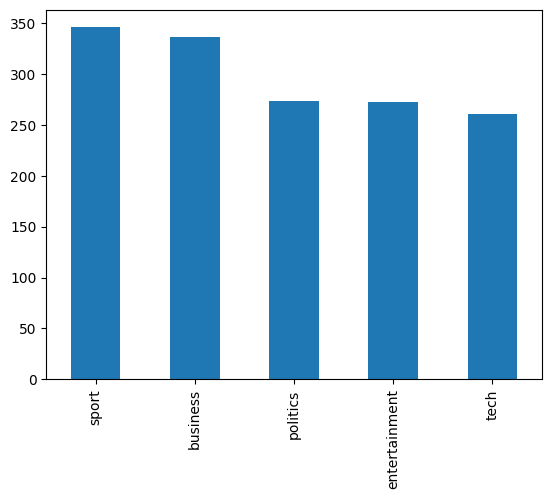

In [11]:
df['Category'].value_counts().plot(kind='bar')

The categories are quite evenly distributed. So, the dataset is good.

### Data Cleaning

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[nltk_data] Downloading package stopwords to /home/light/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
import string

def remove_punctuation_and_stop_words(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if not word in stop_words]
    table = str.maketrans('', '', string.punctuation)
    clean_tokens = [word.translate(table) for word in tokens]
    
    clean_tokens = ' '.join(clean_tokens)
    
    return clean_tokens

In [14]:
df['clean_text'] = df['Text'].apply(remove_punctuation_and_stop_words)

In [15]:
def bigram_freq(category):
    clean_text = df[df['Category'] == category]['clean_text']
    words = [word.lower() for text in clean_text for word in nltk.word_tokenize(text)]
    bigrams = list(nltk.bigrams(words))
    bigrams_freq = nltk.FreqDist(bigrams)
    return bigrams_freq

In [16]:
def print_bigrams_freq(bigrams_freq, n=20):
    for bigram, freq in bigrams_freq.most_common(n):
        print(f"{bigram[0]:<10} {bigram[1]:<10} {freq}")

In [17]:
sport_news_bigrams_freq = bigram_freq('sport')
print_bigrams_freq(sport_news_bigrams_freq)

six        nations    113
new        zealand    68
world      cup        62
champions  league     57
grand      slam       56
told       bbc        53
australian open       52
manchester united     46
davis      cup        42
last       year       40
bbc        sport      37
first      time       33
number     one        32
world      number     31
second     half       30
first      half       28
south      africa     27
real       madrid     25
two        years      23
years      ago        23


In [18]:
business_news_bigrams_freq = bigram_freq('business')
print_bigrams_freq(business_news_bigrams_freq)


last       year       111
chief      executive  80
economic   growth     53
interest   rates      49
analysts   said       44
stock      market     42
mr         glazer     40
new        york       37
mr         ebbers     35
three      months     35
oil        prices     35
last       week       33
consumer   spending   32
deutsche   boerse     32
stock      exchange   31
said       would      30
also       said       29
said       mr         28
sri        lanka      28
south      korea      25


In [19]:
politics_news_bigrams_freq = bigram_freq('politics')
print_bigrams_freq(politics_news_bigrams_freq)

mr         blair      222
prime      minister   191
mr         brown      165
tony       blair      124
general    election   119
mr         howard     92
told       bbc        87
michael    howard     83
lib        dems       77
said       mr         74
liberal    democrats  72
home       secretary  69
gordon     brown      69
mr         kennedy    59
lib        dem        56
human      rights     54
blair      said       52
said       would      51
council    tax        49
election   campaign   46


In [20]:
entertainment_news_bigrams_freq = bigram_freq('entertainment')
print_bigrams_freq(entertainment_news_bigrams_freq)

box        office     64
last       year       63
number     one        58
new        york       46
best       film       43
named      best       41
los        angeles    39
vera       drake      39
million    dollar     37
dollar     baby       37
best       actress    36
best       director   33
best       actor      31
jamie      foxx       30
best       supporting 27
film       festival   27
first      time       26
imelda     staunton   25
academy    awards     25
martin     scorsese   25


In [21]:
tech_news_bigrams_freq = bigram_freq('tech')
print_bigrams_freq(tech_news_bigrams_freq)

said       mr         133
mobile     phone      73
bbc        news       60
mobile     phones     58
told       bbc        57
news       website    50
mac        mini       45
consumer   electronics 41
last       year       38
digital    music      31
next       generation 30
hard       drive      28
music      players    27
camera     phones     26
digital    cameras    26
operating  system     25
ask        jeeves     25
said       would      24
around     world      23
let        people     22


### Building the Model

I will use TF-IDF as it is a common term 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

y = df['Category']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


#### Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Both approaches have pros and cons. I will first try both approaches.

In [24]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5)
nmf.fit(X_train)

NMF(n_components=5)

In [25]:
nmf.components_

array([[0.00969737, 0.02377681, 0.00060094, ..., 0.01913484, 0.00082115,
        0.01196767],
       [0.00111219, 0.05433153, 0.00036562, ..., 0.        , 0.        ,
        0.        ],
       [0.00059533, 0.07573312, 0.00022178, ..., 0.        , 0.00023743,
        0.        ],
       [0.        , 0.02785081, 0.        , ..., 0.        , 0.00142231,
        0.00021985],
       [0.        , 0.08357815, 0.00016119, ..., 0.00035104, 0.        ,
        0.        ]])

In [26]:
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

In [27]:
X_train_nmf[0]

array([0.14642156, 0.        , 0.00246008, 0.        , 0.        ])

In [32]:
X_train_nmf.shape

(1192, 5)

In [62]:
y_train_pred = np.argmax(X_train_nmf, axis=1)

In [64]:
from sklearn.metrics import accuracy_score

In [58]:
import itertools

def permute_list(elements):
    # Generate all permutations of the list
    permutations_list = list(itertools.permutations(elements))
    
    return permutations_list

def label_permute_compare(y, predictions):
    categories = ['business', 'tech', 'politics', 'sport', 'entertainment']
    permutations = permute_list(categories)
    max_accuracy = -1
    label_order = None
    
    for permute in permutations:
        label_predictions = [permute[i] for i in predictions]
        accuracy = accuracy_score(y, label_predictions)
        
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            label_order = permute

    return label_order, max_accuracy

In [65]:
label_order, max_accuracy = label_permute_compare(y_train, y_train_pred)

In [66]:
print(label_order, max_accuracy)

('sport', 'politics', 'tech', 'entertainment', 'business') 0.9093959731543624


In [67]:
y_test_pred = np.argmax(X_test_nmf, axis=1)

#### Accuracy_score on y test

In [68]:
accuracy_score(y_test, [['sport', 'politics', 'tech', 'entertainment', 'business'][i] for i in y_test_pred])

0.9328859060402684

### Submission

In [69]:
df_test = pd.read_csv('./data/test.csv')
df_test['clean_text'] = df_test['Text'].apply(remove_punctuation_and_stop_words)
df_test_tfidf = tfidf_vectorizer.transform(df_test['clean_text'])

In [72]:
nmf.fit(df_test_tfidf)

NMF(n_components=5)

In [74]:
df_test_tfidf_nmf = nmf.transform(df_test_tfidf)

In [75]:
df_test_pred = np.argmax(df_test_tfidf_nmf, axis=1)

In [76]:
df_test_pred = [['sport', 'politics', 'tech', 'entertainment', 'business'][i] for i in df_test_pred]

In [78]:
df_test['prediction'] = df_test_pred

In [80]:
df_test[['ArticleId', 'prediction']]

,ArticleId,prediction
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,tech
4,1020,sport
...,...,...
730,1923,tech
731,373,business
732,1704,entertainment
733,206,tech


In [82]:
df_test[['ArticleId', 'prediction']].to_csv('./submission.csv', index=False)

### Supervised Learning approach

In [83]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_nmf, y_train)

accuracy = model.score(X_test_nmf, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8993288590604027


In [85]:
accuracy_score(y_test, model.predict(X_test_nmf))

0.8993288590604027

In [87]:
df_test['supervised_prediction'] = model.predict(df_test_tfidf_nmf)

In [88]:
df_test[['ArticleId', 'supervised_prediction']].to_csv('./super_submission.csv', index=False)

In [92]:
nmf_model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
nmf_model.fit(X_train)
X_train_nmf = nmf_model.transform(X_train)

In [93]:
y_train_pred = np.argmax(X_train_nmf, axis=1)

In [94]:
accuracy_score(y_train, [['sport', 'politics', 'tech', 'entertainment', 'business'][i] for i in y_train_pred])

0.9295302013422819

In [95]:
y_test_pred = np.argmax(nmf_model.transform(X_test), axis=1)

In [96]:
accuracy_score(y_test, [['sport', 'politics', 'tech', 'entertainment', 'business'][i] for i in y_test_pred])

0.9630872483221476

In [97]:
df_test_pred = np.argmax(nmf_model.transform(df_test_tfidf), axis=1)

In [98]:
df_test['new_new_prediction'] = [['sport', 'politics', 'tech', 'entertainment', 'business'][i] for i in df_test_pred]

In [99]:
df_test[['ArticleId', 'new_new_prediction']].to_csv('./new_new_submission.csv', index=False)